In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

### Importing data and grabbing important features

In [2]:
vn30f_1min = pd.read_csv(r"../data/VN30F1M_1min_cleaned.csv",parse_dates=[0],index_col=0)
vn30_1min = pd.read_csv(r"../data/VN30_1min_cleaned.csv",parse_dates=[0],index_col=0)

In [3]:
vn30f_1min = vn30f_1min[['close', 'volume', 'buy_volume', 'sell_volume', 'days_to_maturity', 'day_of_week']]
vn30_1min = vn30_1min['close'].to_frame()

In [4]:
df = vn30_1min.merge(vn30f_1min, how='left', left_index=True, right_index=True,  suffixes=('_spot', '_future'))

In [5]:
df["future_spread"] = df["close_future"] - df["close_spot"] 

In [6]:
df["net_volume"] = df["buy_volume"] - df["sell_volume"]

In [7]:
df["cum_sum_volume"] = df["volume"].groupby(pd.Grouper(freq='D')).cumsum()
df["cum_buy_volume"] = df["buy_volume"].groupby(pd.Grouper(freq='D')).cumsum()
df["cum_sell_volume"] = df["sell_volume"].groupby(pd.Grouper(freq='D')).cumsum()

In [8]:
df["hour"] = df.index.hour
df["minute"] = df.index.minute

In [9]:
df.describe()

,close_spot,close_future,volume,buy_volume,sell_volume,days_to_maturity,day_of_week,future_spread,net_volume,cum_sum_volume,cum_buy_volume,cum_sell_volume,hour,minute
count,139442.000000,139442.000000,139442.000000,139442.000000,139442.000000,139442.000000,139442.000000,139442.00000,139442.000000,139442.000000,139442.000000,139442.000000,139442.000000,139442.000000
mean,1280.321300,1277.953211,928.786291,497.722824,430.614112,11.701783,2.011345,-2.36809,67.108712,91130.957222,48728.909382,42349.012091,11.287611,27.079646
std,190.251386,190.726628,778.125674,491.345557,438.418695,7.502714,1.406704,6.40272,511.432865,78301.500694,42938.283704,35844.903844,1.804996,16.639464
min,863.710000,861.600000,1.000000,0.000000,0.000000,1.000000,0.000000,-35.69000,-12183.000000,88.000000,0.000000,0.000000,9.000000,0.000000
25%,1086.012500,1082.800000,400.000000,178.000000,151.000000,6.000000,1.000000,-6.04000,-136.000000,33095.250000,17324.000000,15572.000000,10.000000,14.000000
50%,1274.190000,1268.350000,704.000000,348.000000,300.000000,11.000000,2.000000,-2.20000,37.000000,71068.000000,37504.500000,33300.000000,11.000000,25.000000
75%,1478.450000,1479.900000,1208.000000,643.000000,560.000000,17.000000,3.000000,1.21000,246.000000,125878.750000,66878.750000,58685.000000,13.000000,41.000000
max,1586.630000,1576.700000,16149.000000,16009.000000,12183.000000,37.000000,4.000000,36.01000,15869.000000,590379.000000,329729.000000,260650.000000,14.000000,59.000000


In [10]:
df = df.replace(0, np.nan)
df = df.replace(0.0, np.nan)

### Creating functions to get historical pct change of features and future pct change of price

In [11]:
def get_pct_change(df, fields: list, interval: int) -> pd.DataFrame():
    for field in fields:
        #df[field + "_relative_diff"] = df[field].pct_change(interval) * 100
        
        df[field + "_relative_diff"] = np.where((df[field].shift(interval) != 0.0) & (df[field] != 0.0), df[field].pct_change(interval) * 100, np.nan)
    return df

In [12]:
def get_future_pct_change(df, field, interval:int) -> pd.DataFrame():
    df[field + "_relative_diff_forward"] = (df[field].shift(-interval) - df[field]) / df[field] * 100
    return df

In [13]:
# Function to assign 0, 1, or 2 based on outcome values
def assign_value(value, threshold):
    if value < -threshold:
        return 0
    elif value > threshold:
        return 1
    else:
        return 2

### Specifying XGB Classifier Model

In [14]:
def xgb_classifier_accuracy(X, y, k):
    xgb_classifier = xgb.XGBClassifier(
    objective='multi:softmax',
    learning_rate=0.01,
    max_depth=3,
    n_estimators=100,
    n_jobs=-1)
    
    accuracy_scores = cross_val_score(xgb_classifier, X, y, cv=k)
    return accuracy_scores.mean()

## Testing XGBoost Models at Different 10 Time Intervals & 10 Threshold Levels
### Recording the proportion of y that meet the thresholds and mean accuracy from K-Fold (K=5) Cross-Validation

In [15]:
# 10 intervals by 10 thresholds
intervals = [1, 2, 5, 10, 15, 30, 60, 90, 120, 240]
thresholds = [0.01, 0.02, 0.035, 0.05, 0.1, 0.2, 0.35, 0.5, 1, 1.5, 2]

In [16]:
# Definte empty lists to hold results to be added to dictionary
results = {}
proportion_ls = []
accuracy_ls = []
interval_ls = []
threshold_ls = []
periods_ls = []

In [17]:
import xgboost as xgb
from sklearn.model_selection import cross_val_score
from tqdm import tqdm

# Get average accuracy score based on 5-Fold Cross Validation for XGBoost Classifier models.
for threshold in thresholds:
    
    for interval in tqdm(intervals):
        data = df
        data = get_pct_change(data, ["close_spot", "close_future", "future_spread", "cum_sum_volume", "cum_buy_volume", "cum_sell_volume"], interval=interval)
        data = get_future_pct_change(data, "close_future", interval = interval)
        data["y_values"] = data["close_future_relative_diff_forward"].apply(assign_value, args=(threshold,))
        
        data = data.dropna(axis="rows", how="any")
        
        # Fit XGB Classifier
        y = data["y_values"]
        X = data.drop(axis="columns", labels=["y_values", "close_future_relative_diff_forward"])
        
        total_periods = len(data["y_values"])
        proportion = len(data[(data["y_values"] == 0) | (data["y_values"] == 1)]) / total_periods
        accuracy_score = xgb_classifier_accuracy(X, y, 5)
        
        # Append results
        proportion_ls.append(proportion)
        accuracy_ls.append(accuracy_score)
        interval_ls.append(interval)
        threshold_ls.append(threshold)
        periods_ls.append(total_periods)
        
        # Print results
        print(f"Outside Threshold Proportion: {round(proportion,3)}, Accuracy: {round(accuracy_score, 3)}, Interval: {interval}, Threshold: {threshold}")

 10%|████▍                                       | 1/10 [00:37<05:33, 37.04s/it]

Outside Threshold Proportion: 0.785, Accuracy: 0.442, Interval: 1, Threshold: 0.01


 20%|████████▊                                   | 2/10 [01:10<04:40, 35.07s/it]

Outside Threshold Proportion: 0.839, Accuracy: 0.426, Interval: 2, Threshold: 0.01


 30%|█████████████▏                              | 3/10 [01:42<03:53, 33.38s/it]

Outside Threshold Proportion: 0.898, Accuracy: 0.458, Interval: 5, Threshold: 0.01


 40%|█████████████████▌                          | 4/10 [02:12<03:13, 32.28s/it]

Outside Threshold Proportion: 0.93, Accuracy: 0.484, Interval: 10, Threshold: 0.01


 50%|██████████████████████                      | 5/10 [02:42<02:36, 31.39s/it]

Outside Threshold Proportion: 0.943, Accuracy: 0.458, Interval: 15, Threshold: 0.01


 60%|██████████████████████████▍                 | 6/10 [03:14<02:06, 31.70s/it]

Outside Threshold Proportion: 0.962, Accuracy: 0.455, Interval: 30, Threshold: 0.01


 70%|██████████████████████████████▊             | 7/10 [03:44<01:33, 31.10s/it]

Outside Threshold Proportion: 0.977, Accuracy: 0.458, Interval: 60, Threshold: 0.01


 80%|███████████████████████████████████▏        | 8/10 [04:14<01:01, 30.68s/it]

Outside Threshold Proportion: 0.982, Accuracy: 0.47, Interval: 90, Threshold: 0.01


 90%|███████████████████████████████████████▌    | 9/10 [04:43<00:30, 30.20s/it]

Outside Threshold Proportion: 0.985, Accuracy: 0.465, Interval: 120, Threshold: 0.01


100%|███████████████████████████████████████████| 10/10 [05:14<00:00, 31.45s/it]


Outside Threshold Proportion: 0.991, Accuracy: 0.499, Interval: 240, Threshold: 0.01


 10%|████▍                                       | 1/10 [00:31<04:44, 31.59s/it]

Outside Threshold Proportion: 0.516, Accuracy: 0.5, Interval: 1, Threshold: 0.03


 20%|████████▊                                   | 2/10 [01:03<04:12, 31.62s/it]

Outside Threshold Proportion: 0.616, Accuracy: 0.41, Interval: 2, Threshold: 0.03


 30%|█████████████▏                              | 3/10 [01:34<03:39, 31.31s/it]

Outside Threshold Proportion: 0.747, Accuracy: 0.388, Interval: 5, Threshold: 0.03


 40%|█████████████████▌                          | 4/10 [02:07<03:12, 32.03s/it]

Outside Threshold Proportion: 0.823, Accuracy: 0.425, Interval: 10, Threshold: 0.03


 50%|██████████████████████                      | 5/10 [02:37<02:36, 31.31s/it]

Outside Threshold Proportion: 0.855, Accuracy: 0.408, Interval: 15, Threshold: 0.03


 60%|██████████████████████████▍                 | 6/10 [03:07<02:03, 30.94s/it]

Outside Threshold Proportion: 0.904, Accuracy: 0.417, Interval: 30, Threshold: 0.03


 70%|██████████████████████████████▊             | 7/10 [03:36<01:31, 30.45s/it]

Outside Threshold Proportion: 0.94, Accuracy: 0.442, Interval: 60, Threshold: 0.03


 80%|███████████████████████████████████▏        | 8/10 [04:09<01:01, 30.99s/it]

Outside Threshold Proportion: 0.954, Accuracy: 0.461, Interval: 90, Threshold: 0.03


 90%|███████████████████████████████████████▌    | 9/10 [04:38<00:30, 30.59s/it]

Outside Threshold Proportion: 0.96, Accuracy: 0.469, Interval: 120, Threshold: 0.03


100%|███████████████████████████████████████████| 10/10 [05:07<00:00, 30.79s/it]


Outside Threshold Proportion: 0.978, Accuracy: 0.492, Interval: 240, Threshold: 0.03


 10%|████▍                                       | 1/10 [00:29<04:28, 29.84s/it]

Outside Threshold Proportion: 0.335, Accuracy: 0.663, Interval: 1, Threshold: 0.05


 20%|████████▊                                   | 2/10 [01:02<04:13, 31.71s/it]

Outside Threshold Proportion: 0.441, Accuracy: 0.553, Interval: 2, Threshold: 0.05


 30%|█████████████▏                              | 3/10 [01:34<03:42, 31.82s/it]

Outside Threshold Proportion: 0.605, Accuracy: 0.431, Interval: 5, Threshold: 0.05


 40%|█████████████████▌                          | 4/10 [02:07<03:13, 32.31s/it]

Outside Threshold Proportion: 0.715, Accuracy: 0.401, Interval: 10, Threshold: 0.05


 50%|██████████████████████                      | 5/10 [02:38<02:39, 31.82s/it]

Outside Threshold Proportion: 0.764, Accuracy: 0.362, Interval: 15, Threshold: 0.05


 60%|██████████████████████████▍                 | 6/10 [03:11<02:07, 31.98s/it]

Outside Threshold Proportion: 0.842, Accuracy: 0.389, Interval: 30, Threshold: 0.05


 70%|██████████████████████████████▊             | 7/10 [03:41<01:34, 31.44s/it]

Outside Threshold Proportion: 0.9, Accuracy: 0.419, Interval: 60, Threshold: 0.05


 80%|███████████████████████████████████▏        | 8/10 [04:11<01:01, 30.90s/it]

Outside Threshold Proportion: 0.923, Accuracy: 0.443, Interval: 90, Threshold: 0.05


 90%|███████████████████████████████████████▌    | 9/10 [04:41<00:30, 30.80s/it]

Outside Threshold Proportion: 0.934, Accuracy: 0.464, Interval: 120, Threshold: 0.05


100%|███████████████████████████████████████████| 10/10 [05:13<00:00, 31.32s/it]


Outside Threshold Proportion: 0.964, Accuracy: 0.493, Interval: 240, Threshold: 0.05


 10%|████▍                                       | 1/10 [00:31<04:45, 31.77s/it]

Outside Threshold Proportion: 0.228, Accuracy: 0.769, Interval: 1, Threshold: 0.07


 20%|████████▊                                   | 2/10 [01:02<04:10, 31.37s/it]

Outside Threshold Proportion: 0.327, Accuracy: 0.665, Interval: 2, Threshold: 0.07


 30%|█████████████▏                              | 3/10 [01:35<03:44, 32.11s/it]

Outside Threshold Proportion: 0.496, Accuracy: 0.511, Interval: 5, Threshold: 0.07


 40%|█████████████████▌                          | 4/10 [02:07<03:11, 31.91s/it]

Outside Threshold Proportion: 0.625, Accuracy: 0.43, Interval: 10, Threshold: 0.07


 50%|██████████████████████                      | 5/10 [02:38<02:37, 31.55s/it]

Outside Threshold Proportion: 0.688, Accuracy: 0.381, Interval: 15, Threshold: 0.07


 60%|██████████████████████████▍                 | 6/10 [03:08<02:04, 31.24s/it]

Outside Threshold Proportion: 0.785, Accuracy: 0.355, Interval: 30, Threshold: 0.07


 70%|██████████████████████████████▊             | 7/10 [03:40<01:33, 31.26s/it]

Outside Threshold Proportion: 0.862, Accuracy: 0.394, Interval: 60, Threshold: 0.07


 80%|███████████████████████████████████▏        | 8/10 [04:09<01:01, 30.72s/it]

Outside Threshold Proportion: 0.893, Accuracy: 0.427, Interval: 90, Threshold: 0.07


 90%|███████████████████████████████████████▌    | 9/10 [04:39<00:30, 30.32s/it]

Outside Threshold Proportion: 0.908, Accuracy: 0.452, Interval: 120, Threshold: 0.07


100%|███████████████████████████████████████████| 10/10 [05:08<00:00, 30.88s/it]


Outside Threshold Proportion: 0.95, Accuracy: 0.479, Interval: 240, Threshold: 0.07


 10%|████▍                                       | 1/10 [00:32<04:48, 32.03s/it]

Outside Threshold Proportion: 0.16, Accuracy: 0.834, Interval: 1, Threshold: 0.09


 20%|████████▊                                   | 2/10 [01:01<04:05, 30.72s/it]

Outside Threshold Proportion: 0.248, Accuracy: 0.74, Interval: 2, Threshold: 0.09


 30%|█████████████▏                              | 3/10 [01:31<03:32, 30.36s/it]

Outside Threshold Proportion: 0.41, Accuracy: 0.581, Interval: 5, Threshold: 0.09


 40%|█████████████████▌                          | 4/10 [02:02<03:03, 30.51s/it]

Outside Threshold Proportion: 0.547, Accuracy: 0.476, Interval: 10, Threshold: 0.09


 50%|██████████████████████                      | 5/10 [02:35<02:36, 31.40s/it]

Outside Threshold Proportion: 0.617, Accuracy: 0.418, Interval: 15, Threshold: 0.09


 60%|██████████████████████████▍                 | 6/10 [03:06<02:05, 31.29s/it]

Outside Threshold Proportion: 0.73, Accuracy: 0.353, Interval: 30, Threshold: 0.09


 70%|██████████████████████████████▊             | 7/10 [03:36<01:32, 30.78s/it]

Outside Threshold Proportion: 0.824, Accuracy: 0.38, Interval: 60, Threshold: 0.09


 80%|███████████████████████████████████▏        | 8/10 [04:05<01:00, 30.37s/it]

Outside Threshold Proportion: 0.862, Accuracy: 0.402, Interval: 90, Threshold: 0.09


 90%|███████████████████████████████████████▌    | 9/10 [04:37<00:30, 30.86s/it]

Outside Threshold Proportion: 0.884, Accuracy: 0.438, Interval: 120, Threshold: 0.09


100%|███████████████████████████████████████████| 10/10 [05:07<00:00, 30.74s/it]


Outside Threshold Proportion: 0.937, Accuracy: 0.468, Interval: 240, Threshold: 0.09


 10%|████▍                                       | 1/10 [00:29<04:24, 29.34s/it]

Outside Threshold Proportion: 0.116, Accuracy: 0.878, Interval: 1, Threshold: 0.11


 20%|████████▊                                   | 2/10 [00:59<03:58, 29.78s/it]

Outside Threshold Proportion: 0.192, Accuracy: 0.802, Interval: 2, Threshold: 0.11


 30%|█████████████▏                              | 3/10 [01:31<03:35, 30.78s/it]

Outside Threshold Proportion: 0.345, Accuracy: 0.645, Interval: 5, Threshold: 0.11


 40%|█████████████████▌                          | 4/10 [02:02<03:04, 30.82s/it]

Outside Threshold Proportion: 0.48, Accuracy: 0.526, Interval: 10, Threshold: 0.11


 50%|██████████████████████                      | 5/10 [02:33<02:35, 31.09s/it]

Outside Threshold Proportion: 0.554, Accuracy: 0.466, Interval: 15, Threshold: 0.11


 60%|██████████████████████████▍                 | 6/10 [03:05<02:05, 31.35s/it]

Outside Threshold Proportion: 0.68, Accuracy: 0.377, Interval: 30, Threshold: 0.11


 70%|██████████████████████████████▊             | 7/10 [03:39<01:36, 32.04s/it]

Outside Threshold Proportion: 0.787, Accuracy: 0.361, Interval: 60, Threshold: 0.11


 80%|███████████████████████████████████▏        | 8/10 [04:11<01:04, 32.12s/it]

Outside Threshold Proportion: 0.832, Accuracy: 0.38, Interval: 90, Threshold: 0.11


 90%|███████████████████████████████████████▌    | 9/10 [04:41<00:31, 31.37s/it]

Outside Threshold Proportion: 0.86, Accuracy: 0.414, Interval: 120, Threshold: 0.11


100%|███████████████████████████████████████████| 10/10 [05:10<00:00, 31.06s/it]


Outside Threshold Proportion: 0.924, Accuracy: 0.469, Interval: 240, Threshold: 0.11


 10%|████▍                                       | 1/10 [00:31<04:45, 31.68s/it]

Outside Threshold Proportion: 0.087, Accuracy: 0.905, Interval: 1, Threshold: 0.13


 20%|████████▊                                   | 2/10 [01:01<04:03, 30.42s/it]

Outside Threshold Proportion: 0.152, Accuracy: 0.841, Interval: 2, Threshold: 0.13


 30%|█████████████▏                              | 3/10 [01:30<03:29, 29.99s/it]

Outside Threshold Proportion: 0.291, Accuracy: 0.701, Interval: 5, Threshold: 0.13


 40%|█████████████████▌                          | 4/10 [02:01<03:00, 30.15s/it]

Outside Threshold Proportion: 0.424, Accuracy: 0.57, Interval: 10, Threshold: 0.13


 50%|██████████████████████                      | 5/10 [02:33<02:35, 31.11s/it]

Outside Threshold Proportion: 0.5, Accuracy: 0.509, Interval: 15, Threshold: 0.13


 60%|██████████████████████████▍                 | 6/10 [03:05<02:05, 31.39s/it]

Outside Threshold Proportion: 0.633, Accuracy: 0.412, Interval: 30, Threshold: 0.13


 70%|██████████████████████████████▊             | 7/10 [03:37<01:34, 31.53s/it]

Outside Threshold Proportion: 0.752, Accuracy: 0.36, Interval: 60, Threshold: 0.13


 80%|███████████████████████████████████▏        | 8/10 [04:10<01:03, 31.79s/it]

Outside Threshold Proportion: 0.803, Accuracy: 0.373, Interval: 90, Threshold: 0.13


 90%|███████████████████████████████████████▌    | 9/10 [04:41<00:31, 31.80s/it]

Outside Threshold Proportion: 0.837, Accuracy: 0.4, Interval: 120, Threshold: 0.13


100%|███████████████████████████████████████████| 10/10 [05:12<00:00, 31.23s/it]


Outside Threshold Proportion: 0.91, Accuracy: 0.461, Interval: 240, Threshold: 0.13


 10%|████▍                                       | 1/10 [00:32<04:50, 32.30s/it]

Outside Threshold Proportion: 0.066, Accuracy: 0.926, Interval: 1, Threshold: 0.15


 20%|████████▊                                   | 2/10 [01:04<04:19, 32.48s/it]

Outside Threshold Proportion: 0.121, Accuracy: 0.87, Interval: 2, Threshold: 0.15


 30%|█████████████▏                              | 3/10 [01:35<03:40, 31.54s/it]

Outside Threshold Proportion: 0.249, Accuracy: 0.744, Interval: 5, Threshold: 0.15


 40%|█████████████████▌                          | 4/10 [02:05<03:06, 31.16s/it]

Outside Threshold Proportion: 0.376, Accuracy: 0.612, Interval: 10, Threshold: 0.15


 50%|██████████████████████                      | 5/10 [02:37<02:36, 31.27s/it]

Outside Threshold Proportion: 0.452, Accuracy: 0.547, Interval: 15, Threshold: 0.15


 60%|██████████████████████████▍                 | 6/10 [03:10<02:07, 31.99s/it]

Outside Threshold Proportion: 0.588, Accuracy: 0.449, Interval: 30, Threshold: 0.15


 70%|██████████████████████████████▊             | 7/10 [03:42<01:35, 31.78s/it]

Outside Threshold Proportion: 0.717, Accuracy: 0.368, Interval: 60, Threshold: 0.15


 80%|███████████████████████████████████▏        | 8/10 [04:13<01:03, 31.50s/it]

Outside Threshold Proportion: 0.776, Accuracy: 0.363, Interval: 90, Threshold: 0.15


 90%|███████████████████████████████████████▌    | 9/10 [04:44<00:31, 31.43s/it]

Outside Threshold Proportion: 0.814, Accuracy: 0.38, Interval: 120, Threshold: 0.15


100%|███████████████████████████████████████████| 10/10 [05:16<00:00, 31.66s/it]


Outside Threshold Proportion: 0.896, Accuracy: 0.454, Interval: 240, Threshold: 0.15


 10%|████▍                                       | 1/10 [00:29<04:26, 29.62s/it]

Outside Threshold Proportion: 0.051, Accuracy: 0.941, Interval: 1, Threshold: 0.17


 20%|████████▊                                   | 2/10 [00:59<03:57, 29.72s/it]

Outside Threshold Proportion: 0.099, Accuracy: 0.892, Interval: 2, Threshold: 0.17


 30%|█████████████▏                              | 3/10 [01:29<03:29, 29.87s/it]

Outside Threshold Proportion: 0.213, Accuracy: 0.78, Interval: 5, Threshold: 0.17


 40%|█████████████████▌                          | 4/10 [02:02<03:07, 31.23s/it]

Outside Threshold Proportion: 0.335, Accuracy: 0.652, Interval: 10, Threshold: 0.17


 50%|██████████████████████                      | 5/10 [02:33<02:35, 31.14s/it]

Outside Threshold Proportion: 0.409, Accuracy: 0.581, Interval: 15, Threshold: 0.17


 60%|██████████████████████████▍                 | 6/10 [03:05<02:04, 31.22s/it]

Outside Threshold Proportion: 0.547, Accuracy: 0.475, Interval: 30, Threshold: 0.17


 70%|██████████████████████████████▊             | 7/10 [03:37<01:34, 31.65s/it]

Outside Threshold Proportion: 0.684, Accuracy: 0.382, Interval: 60, Threshold: 0.17


 80%|███████████████████████████████████▏        | 8/10 [04:10<01:04, 32.01s/it]

Outside Threshold Proportion: 0.749, Accuracy: 0.364, Interval: 90, Threshold: 0.17


 90%|███████████████████████████████████████▌    | 9/10 [04:41<00:31, 31.63s/it]

Outside Threshold Proportion: 0.791, Accuracy: 0.372, Interval: 120, Threshold: 0.17


100%|███████████████████████████████████████████| 10/10 [05:11<00:00, 31.12s/it]


Outside Threshold Proportion: 0.883, Accuracy: 0.444, Interval: 240, Threshold: 0.17


 10%|████▍                                       | 1/10 [00:31<04:45, 31.77s/it]

Outside Threshold Proportion: 0.04, Accuracy: 0.953, Interval: 1, Threshold: 0.19


 20%|████████▊                                   | 2/10 [01:01<04:05, 30.71s/it]

Outside Threshold Proportion: 0.08, Accuracy: 0.912, Interval: 2, Threshold: 0.19


 30%|█████████████▏                              | 3/10 [01:31<03:32, 30.30s/it]

Outside Threshold Proportion: 0.184, Accuracy: 0.808, Interval: 5, Threshold: 0.19


 40%|█████████████████▌                          | 4/10 [02:01<03:01, 30.18s/it]

Outside Threshold Proportion: 0.299, Accuracy: 0.691, Interval: 10, Threshold: 0.19


 50%|██████████████████████                      | 5/10 [02:34<02:36, 31.27s/it]

Outside Threshold Proportion: 0.372, Accuracy: 0.62, Interval: 15, Threshold: 0.19


 60%|██████████████████████████▍                 | 6/10 [03:06<02:05, 31.36s/it]

Outside Threshold Proportion: 0.51, Accuracy: 0.505, Interval: 30, Threshold: 0.19


 70%|██████████████████████████████▊             | 7/10 [03:37<01:34, 31.47s/it]

Outside Threshold Proportion: 0.653, Accuracy: 0.388, Interval: 60, Threshold: 0.19


 80%|███████████████████████████████████▏        | 8/10 [04:09<01:02, 31.35s/it]

Outside Threshold Proportion: 0.722, Accuracy: 0.372, Interval: 90, Threshold: 0.19


 90%|███████████████████████████████████████▌    | 9/10 [04:42<00:32, 32.00s/it]

Outside Threshold Proportion: 0.769, Accuracy: 0.362, Interval: 120, Threshold: 0.19


100%|███████████████████████████████████████████| 10/10 [05:12<00:00, 31.25s/it]

Outside Threshold Proportion: 0.869, Accuracy: 0.43, Interval: 240, Threshold: 0.19


In [25]:
results = {"Proportion": proportion_ls, "Accuracy": accuracy_ls, "Interval": interval_ls, "Threshold": threshold_ls, "Period": periods_ls}

In [26]:
results_df = pd.DataFrame(results, index = None)

### Graphing the results

In [29]:
results_df

,Proportion,Accuracy,Interval,Threshold,Period
0,0.784730,0.442195,1,0.01,109402
1,0.839278,0.426188,2,0.01,109400
2,0.898294,0.458050,5,0.01,109394
3,0.929633,0.483544,10,0.01,109384
4,0.943213,0.457723,15,0.01,109374
...,...,...,...,...,...
95,0.509548,0.504829,30,0.19,109344
96,0.652902,0.387799,60,0.19,109286
97,0.722301,0.371880,90,0.19,109226
98,0.769145,0.362396,120,0.19,109168


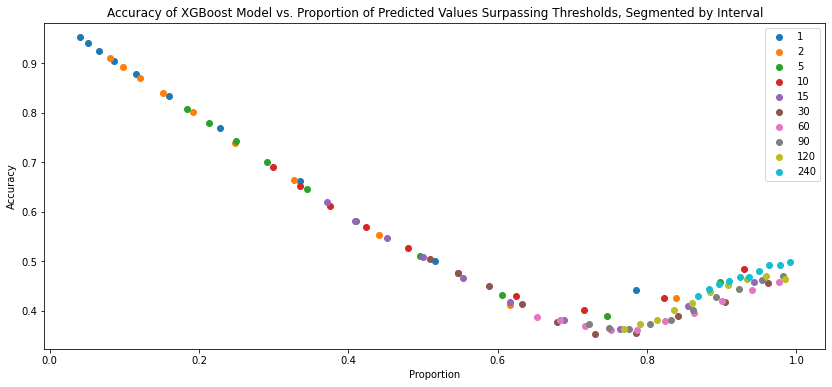

In [36]:
plt.figure(figsize = (14, 6))

intervals = results_df['Interval'].unique()

# Plotting scatter plot for each group
for interval in intervals:
    interval_data = results_df[results_df['Interval'] == interval]
    plt.scatter(interval_data['Proportion'], interval_data['Accuracy'], label=interval)

# Adding labels and title
plt.xlabel('Proportion')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy of XGBoost Model vs. Proportion of Predicted Values Surpassing Thresholds, Segmented by Interval')

# Displaying the plot
plt.show()